## WIP BARRA TC Marcus Case Study

## BARRA2 - Cyclone Marcus 2018-03
https://en.wikipedia.org/wiki/Cyclone_Marcus

- From 2018-03-14 to 2018-03-27
- Category 5
- $75 million damage

#### Load necessary modules

In [2]:
import os
from glob import glob
import xarray as xr
import pandas
from matplotlib import pyplot as plt
import cartopy.crs
from dask.distributed import Client, LocalCluster

In [3]:
# TODO: Is there a better way to do this?
# Jupyter notebooks typically don't run from the file's location
# So we need to change the working directory

# Change notebook working directory to the location of the notebook
# Update the following to the directory containing the notebook file
notebook_dir = "/home/548/jt4085/repos/BARRA2_evaluation/jt/notebooks"
os.chdir(notebook_dir)

In [4]:
from loaddata import load_dataset

In [5]:
# Let's explictly load dask so we can check progress
# Copy and past the dashboard link/path from this cell's output
# to the Dask tab on the left.
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34075,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:36645,Total threads: 1
Dashboard: /proxy/41211/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:45257,


#### Load BARRA2 data for TC Marcus

In [6]:
ds_marcus_u = load_dataset('uas', '1hr', '201803', 'barra')
ds_marcus_v = load_dataset('vas', '1hr', '201803', 'barra')
ds_marcus_p = load_dataset('ps', '1hr', '201803', 'barra')
ds_marcus_precip = load_dataset('pr', '1hr', '201803', 'barra')

#### Examine the datasets

In [ ]:
# Let's look at max and min wind speed over the period
vas_max = ds_marcus_v['vas'].max(dim=['lat', 'lon']).compute()
vas_min = ds_marcus_v['vas'].min(dim=['lat', 'lon']).compute()
uas_max = ds_marcus_u['uas'].max(dim=['lat', 'lon']).compute()
uas_min = ds_marcus_u['uas'].min(dim=['lat', 'lon']).compute()

plt.figure()
vas_max.plot()
vas_min.plot()

plt.figure()
uas_max.plot()
uas_min.plot()

distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:36645 (pid=2686309) exceeded 95% memory budget. Restarting...
distributed.nanny - WARNING - Restarting worker
distributed.worker.memory - WARNING - Worker is at 94% memory usage. Pausing worker.  Process memory: 4.24 GiB -- Worker memory limit: 4.50 GiB
distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.40 GiB -- Worker memory limit: 4.50 GiB
distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:41829 (pid=2686311) exceeded 95% memory budget. Restarting...
distributed.nanny - WARNING - Restarting worker


In [ ]:
# Grab the time for the peak wind speed
max_t = vas_max.idxmax(dim='time')

# Let's grab the index of the peak wind speed too
max_t_index = vas_max.argmax(dim='time')

max_t

In [ ]:
# TODO: Is there a better way to do this?
# Jupyter notebooks typically don't run from the file's location
# So we need to change the working directory

# Change notebook working directory to the location of the notebook
# Update the following to the directory containing the notebook file
notebook_dir = "/home/548/jt4085/repos/BARRA2_evaluation/jt/notebooks"
os.chdir(notebook_dir)

In [ ]:
# Plot the wind field for this time
plt.figure()
ds_marcus_u.sel(time=max_t)['uas'].plot()
plt.figure()
ds_marcus_v.sel(time=max_t)['vas'].plot()

In [ ]:
## Pressure
# Plot pressure as a contour map
ds_marcus_p.sel(time=max_t)['ps'].plot.contourf(levels=20, color='k')

## Precip
# Plot precip as a colour map
# Precipitation is an accumulated field, use the index instead of the value for the peak time
ds_marcus_precip.isel(time=max_t_index)['pr'].plot(cmap='Blues')

## Winds
# Merge u and v
ds_marcus_uv = xr.merge([ds_marcus_u, ds_marcus_v])

# Select the peak wind time and downsample the point density
downsampling_factor = 15
downsampled_peak_ds_marcus_uv = ds_marcus_uv.sel(time=max_t, lon=slice(None, None, downsampling_factor), 
                                                 lat=slice(None, None, downsampling_factor))

downsampled_peak_ds_marcus_uv.plot.quiver(x='lon', y='lat', u='uas', v='vas')

plt.show()
# TODO: Make the below figure not ghastly

In [ ]:
contour_plot = ds_marcus_p.sel(time=max_t)['ps'].plot.contour(levels=10, colors=['k'])
plt.gca().clabel(contour_plot, inline=True, fontsize=6)

In [ ]:
%matplotlib notebook

In [ ]:
import os
from glob import glob
import xarray as xr
import pandas
import cartopy.crs as ccrs
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

In [ ]:
# Let's see if we can animate the figure
# Copied from Emma's example
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.dpi"] = 150
plt.ioff()

delta = 12

In [ ]:
# Initial figure
fig = plt.figure(figsize=(12, 6))
centre_lon = ds_marcus_p['lon'].mean().values
projection = cartopy.crs.PlateCarree(centre_lon)
ax = plt.subplot(111, projection=projection)

t_start_index = 0
t_end_index = len(ds_marcus_p['time']) - 1
t_end_index = 10

## Pressure
# Plot pressure as a contour map
p_contour = ds_marcus_p.isel(time=t_start_index)['ps'].plot.contourf(levels=20, transform=cartopy.crs.PlateCarree(), subplot_kws={"projection": projection})
contour_plot_ref = [p_contour]

## Precip
# Plot precip as a colour map
# Precipitation is an accumulated field, use the index instead of the value for the peak time
p_color = ds_marcus_precip.isel(time=t_start_index)['pr'].plot(cmap='Blues', transform=cartopy.crs.PlateCarree(), subplot_kws={"projection": projection})

## Winds
# Merge u and v
ds_marcus_uv = xr.merge([ds_marcus_u, ds_marcus_v])

# Select the peak wind time and downsample the point density
downsampling_factor = 15
downsampled_peak_ds_marcus_uv = ds_marcus_uv.isel(time=t_start_index).sel(lon=slice(None, None, downsampling_factor),
                                                 lat=slice(None, None, downsampling_factor))

p_quiver = downsampled_peak_ds_marcus_uv.plot.quiver(x='lon', y='lat', u='uas', v='vas', transform=cartopy.crs.PlateCarree(), subplot_kws={"projection": projection})

def animate(t_index):
    # Contours need to be removed and redrawn
    #contour_plot_ref[0].get_paths().clear()

    # Remove the color bar too
    #contour_plot_ref[0].colorbar.remove()
    
    #p_contour = ds_marcus_p.isel(time=t_start_index)['ps'].plot.contourf(levels=20, transform=cartopy.crs.PlateCarree(), subplot_kws={"projection": projection})
    #contour_plot_ref[0] = p_contour

    # Update the color plot's array
    p_color.set_array(ds_marcus_precip.isel(time=t_index)['pr'].values)

    # Update the quiver plots uv
    downsampled_peak_ds_marcus_uv = ds_marcus_uv.isel(time=t_index).sel(lon=slice(None, None, downsampling_factor),
                                                 lat=slice(None, None, downsampling_factor))
    p_quiver.set_UVC(downsampled_peak_ds_marcus_uv['uas'].values, downsampled_peak_ds_marcus_uv['vas'].values)
    

import matplotlib.animation
matplotlib.animation.FuncAnimation(fig, animate, frames=t_end_index - t_start_index )#ds_marcus_p['ps'].time.shape[0]-1)

In [57]:
# Can we track the cyclone?
vars = ["psl"]

file_list = []
for var in vars:
    # Build a string to use with glob
    glob_str = os.path.join(barra_r2_root_path, time_resolution, var, "*", f"*{date}.nc")
    file_list += sorted(glob(glob_str))

In [58]:
ds_psl = xr.open_mfdataset(file_list, parallel=True)

In [100]:
min_indexes = []
for t in ds_psl['time']:
    ds_psl_t = ds_psl.sel(time=t)

    argmin = ds_psl_t['psl'].compute().argmin(dim=['lat', 'lon'])
    min_lat = ds_psl['lat'][argmin['lat']]
    min_lon = ds_psl['lon'][argmin['lon']]
    min_indexes.append((min_lat, min_lon))

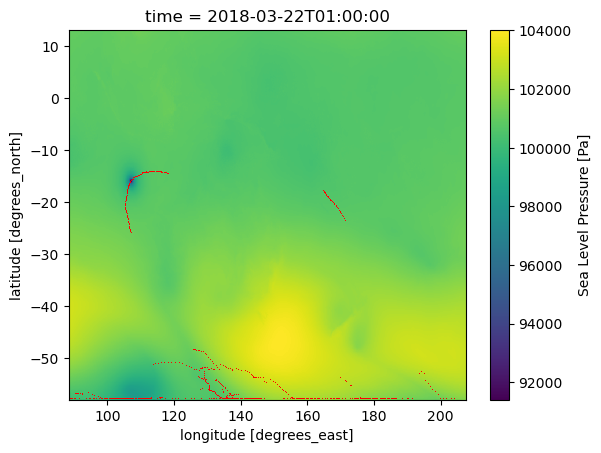

In [103]:
# Let's plot MSLP mins
ds_psl.sel(time="2018-03-22 01:00")['psl'].plot()

for lat, lon in min_indexes:
    plt.plot(lon, lat, 'r,')

In [ ]:
# What does the vorticity look like?
mpcalc.vorticity(ds['uas'], ds['vas'])